# Build toy dataframe

In [2]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = 999

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline

import xgboost

import sklearn
from sklearn.model_selection import train_test_split 

In [3]:
import gc
import time
from subprocess import check_output
print(check_output(["ls", "/Users/jiayou/Dropbox/珺珺的程序/Kaggle/Instacart"]).decode("utf8"))

Instacart Data Exploration.ipynb
README.md
Sample Train.ipynb
Tasks.ipynb
Toy DF.ipynb
aisles.csv
departments.csv
order_products__prior.csv
order_products__train.csv
orders.csv
products.csv
sample_submission.csv
sample_train_submission.csv
training-logs



In [4]:
def load_data(path_data):
    priors = pd.read_csv(path_data + 'order_products__prior.csv', 
                     dtype={
                            'order_id': np.int32,
                            'product_id': np.uint16,
                            'add_to_cart_order': np.int16,
                            'reordered': np.int8})
    train = pd.read_csv(path_data + 'order_products__train.csv', 
                    dtype={
                            'order_id': np.int32,
                            'product_id': np.uint16,
                            'add_to_cart_order': np.int16,
                            'reordered': np.int8})
    orders = pd.read_csv(path_data + 'orders.csv', 
                         dtype={
                                'order_id': np.int32,
                                'user_id': np.int64,
                                'eval_set': 'category',
                                'order_number': np.int16,
                                'order_dow': np.int8,
                                'order_hour_of_day': np.int8,
                                'days_since_prior_order': np.float32})
    
    products = pd.read_csv(path_data + 'products.csv')
    aisles = pd.read_csv(path_data + "aisles.csv")
    departments = pd.read_csv(path_data + "departments.csv")
    sample_submission = pd.read_csv(path_data + "sample_submission.csv")
    
    return priors, train, orders, products, aisles, departments, sample_submission

# orders_df and order_products__prior/train_df shares the 'order_id'
# order_products__prior/train_df and products_df shares the 'product_id'
# products_df and aisles_df shares the 'aisles_id'
# products_df and departments_df shares the 'department id'

In [5]:
class tick_tock:
    def __init__(self, process_name, verbose=1):
        self.process_name = process_name
        self.verbose = verbose
    def __enter__(self):
        if self.verbose:
            print(self.process_name + " begin ......")
            self.begin_time = time.time()
    def __exit__(self, type, value, traceback):
        if self.verbose:
            end_time = time.time()
            print(self.process_name + " end ......")
            print('time lapsing {0} s \n'.format(end_time - self.begin_time))
            
def ka_add_groupby_features_1_vs_n(df, group_columns_list, agg_dict, only_new_feature=True):
    with tick_tock("add stats features"):
        try:
            if type(group_columns_list) == list:
                pass
            else:
                raise TypeError(k + "should be a list")
        except TypeError as e:
            print(e)
            raise

        df_new = df.copy()
        grouped = df_new.groupby(group_columns_list)

        the_stats = grouped.agg(agg_dict)
        the_stats.columns = the_stats.columns.droplevel(0)
        the_stats.reset_index(inplace=True)
        if only_new_feature:
            df_new = the_stats
        else:
            df_new = pd.merge(left=df_new, right=the_stats, on=group_columns_list, how='left')

    return df_new

def ka_add_groupby_features_n_vs_1(df, group_columns_list, target_columns_list, methods_list, keep_only_stats=True, verbose=1):
    with tick_tock("add stats features", verbose):
        dicts = {"group_columns_list": group_columns_list , "target_columns_list": target_columns_list, "methods_list" :methods_list}

        for k, v in dicts.items():
            try:
                if type(v) == list:
                    pass
                else:
                    raise TypeError(k + "should be a list")
            except TypeError as e:
                print(e)
                raise

        grouped_name = ''.join(group_columns_list)
        target_name = ''.join(target_columns_list)
        combine_name = [[grouped_name] + [method_name] + [target_name] for method_name in methods_list]

        df_new = df.copy()
        grouped = df_new.groupby(group_columns_list)

        the_stats = grouped[target_name].agg(methods_list).reset_index()
        the_stats.columns = [grouped_name] + \
                            ['_%s_%s_by_%s' % (grouped_name, method_name, target_name) \
                             for (grouped_name, method_name, target_name) in combine_name]
        if keep_only_stats:
            return the_stats
        else:
            df_new = pd.merge(left=df_new, right=the_stats, on=group_columns_list, how='left')
        return df_new

In [6]:
path_data = "/Users/jiayou/Dropbox/珺珺的程序/Kaggle/Instacart/"
priors, train, orders, products, aisles, departments, sample_submission = load_data(path_data)

In [108]:
products[products.product_name.str.contains('ice cream')]

,product_id,product_name,aisle_id,department_id
19789,19790,Chocolate non-dairy ice cream,37,1


In [109]:
products[products.aisle_id == 37]

,product_id,product_name,aisle_id,department_id
129,130,Vanilla Milk Chocolate Almond Ice Cream Bars M...,37,1
231,232,Blue Bottle Coffee Frozen Bar,37,1
266,267,Triple Chocolate Ripple,37,1
275,276,French Vanilla Ice Cream,37,1
312,313,Peppermint/Banana Split Variety Pack Frozen Da...,37,1
343,344,Lime Sherbet,37,1
395,396,Cashews Natural Unsalted,37,1
430,431,"Ice Cream, Cookies & Cream",37,1
479,480,Slow Churned Mint Chocolate Chip Ice Cream,37,1
496,497,Mascarpone Pistachio Caramel Gelato,37,1


In [92]:
products[products.aisle_id == 27]

,product_id,product_name,aisle_id,department_id
349,350,Mixed 12 Pack Lion's Share Ale,27,5
378,379,Super Dry Beer,27,5
429,430,Born Yesterday Pale Ale,27,5
469,470,Lite Beer,27,5
735,736,"Beer, IPA",27,5
817,818,Micro Craft Beer,27,5
854,855,Clamato Chelada Beer,27,5
959,960,Villager Ipa,27,5
965,966,Pear Hard Cider,27,5
1029,1030,Hop Devil IPA,27,5


In [112]:
# order_item = orders[orders.order_id.isin(priors[priors.product_id.isin(products[products.product_name == 'Banana'].product_id)].order_id)]
order_item = orders[orders.order_id.isin(priors[priors.product_id.isin(products[products.aisle_id == 27].product_id)].order_id)]
order_item

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
227,62373,21,prior,5,1,14,7.0
230,3288630,21,prior,8,2,13,18.0
232,1573906,21,prior,10,3,10,6.0
312,232721,26,prior,12,4,17,7.0
455,1341128,31,prior,7,2,13,2.0
465,2231262,31,prior,17,3,11,8.0
497,412111,36,prior,2,5,18,8.0
498,240889,36,prior,3,5,17,21.0
499,1602446,36,prior,4,1,11,10.0
500,2472897,36,prior,5,4,15,3.0


/Users/jiayou/anaconda/lib/python3.6/site-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/Users/jiayou/anaconda/lib/python3.6/site-packages/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


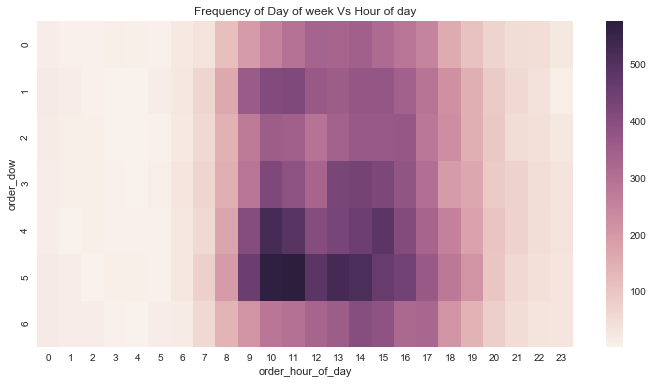

In [113]:
grouped_df = order_item.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Frequency of Day of week Vs Hour of day")
plt.show()

In [34]:
toy_orders = orders[orders.user_id.isin([4,5])]
dsfo = toy_orders.groupby('user_id').days_since_prior_order.cumsum().fillna(0)
toy_orders['days_since_first_order'] = dsfo
max_days = toy_orders.groupby('user_id').days_since_first_order.agg({'max_days':'max'}).reset_index()
toy_orders = toy_orders.merge(max_days, on = 'user_id', how = 'left')
toy_orders['days_to_last_order'] = toy_orders.max_days - toy_orders.days_since_first_order
toy_orders


/Users/jiayou/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,days_since_first_order,max_days,days_to_last_order
0,3343014,4,prior,1,6,11,NaN,0.0,85.0,85.0
1,2030307,4,prior,2,4,11,19.0,19.0,85.0,66.0
2,691089,4,prior,3,4,15,21.0,40.0,85.0,45.0
3,94891,4,prior,4,5,13,15.0,55.0,85.0,30.0
4,2557754,4,prior,5,5,13,0.0,55.0,85.0,30.0
5,329954,4,test,6,3,12,30.0,85.0,85.0,0.0
6,2717275,5,prior,1,3,12,NaN,0.0,46.0,46.0
7,1909121,5,prior,2,0,16,11.0,11.0,46.0,35.0
8,2267326,5,prior,3,3,18,10.0,21.0,46.0,25.0
9,157374,5,prior,4,1,18,19.0,40.0,46.0,6.0


In [48]:
# toy_orders[toy_orders.user_id == 4]
toy_prior[toy_prior.product_id == 7160]

,order_id,product_id,add_to_cart_order,reordered
19249954,2030307,7160,2,0


In [35]:
products[products.aisle_id == 90]
# products.shape
# same category will have same aisle_id, total 134 aisles

,product_id,product_name,aisle_id,department_id
384,385,Liquid Drink Mix Blackberry Lemonade,90,7
463,464,Liquid Water Enhancer Peach Green Tea With Gin...,90,7
762,763,Lemonade Flavor Drink Mix,90,7
841,842,Sugar Free Fruit Juicy Red Drink Mix,90,7
1241,1242,On The Go Fruit Punch Drink Mix,90,7
1594,1595,Tradtional Hot Chocolate Mix,90,7
1805,1806,Strawberry Unsweetened Soft Drink Mix,90,7
2174,2175,Rich Chocolate Hot Cocoa Mix,90,7
2234,2235,Peach Mango Green Tea Drink Mix,90,7
2248,2249,Powdered Grape Drink Mix,90,7


In [36]:
aisles[aisles['aisle'] == 'milk']

,aisle_id,aisle
83,84,milk


In [37]:
departments.head()
# 21 departments

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [38]:
toy_prior = priors[priors.order_id.isin(toy_orders.order_id)]
toy_prior

,order_id,product_id,add_to_cart_order,reordered
897542,94891,22199,1,0
897543,94891,25146,2,0
1492611,157374,27344,1,0
1492612,157374,24535,2,1
1492613,157374,43693,3,1
1492614,157374,40706,4,1
1492615,157374,16168,5,0
1492616,157374,21413,6,1
1492617,157374,13988,7,1
1492618,157374,3376,8,0


In [39]:
toy_prior_order_detail = toy_orders.merge(toy_prior, how = 'inner', on = 'order_id').merge(products, how = 'left', on = 'product_id')
toy_prior_order_detail['user_buy_product_times'] = toy_prior_order_detail.groupby(['user_id', 'product_id']).cumcount() + 1
#用户在此单（包括）之前一共买过几次该商品
toy_prior_order_detail['user_buy_category_times'] = toy_prior_order_detail.groupby(['user_id', 'aisle_id']).cumcount() + 1
toy_prior_order_detail
#用户在此单（包括）之前一共买过几次该种类商品

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,days_since_first_order,max_days,days_to_last_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_buy_product_times,user_buy_category_times
0,3343014,4,prior,1,6,11,NaN,0.0,85.0,85.0,36606,1,0,Sprouted Multi-Grain Bread,112,3,1,1
1,3343014,4,prior,1,6,11,NaN,0.0,85.0,85.0,7350,2,0,Natural Lime Flavor Sparkling Mineral Water,115,7,1,1
2,3343014,4,prior,1,6,11,NaN,0.0,85.0,85.0,35469,3,0,Enchilada Black Bean Vegetable,38,1,1,1
3,3343014,4,prior,1,6,11,NaN,0.0,85.0,85.0,2707,4,0,Complete™ ActionPacs™ Fresh Scent Dishwasher D...,74,17,1,1
4,2030307,4,prior,2,4,11,19.0,19.0,85.0,66.0,42329,1,0,Private Selection Pinot Noir,28,5,1,1
5,2030307,4,prior,2,4,11,19.0,19.0,85.0,66.0,7160,2,0,Clear Cups,111,17,1,1
6,691089,4,prior,3,4,15,21.0,40.0,85.0,45.0,1200,1,0,Vegetable Classics Vegetable Soup,69,15,1,1
7,691089,4,prior,3,4,15,21.0,40.0,85.0,45.0,17769,2,0,Diet Caffeine Free Naturally Flavored Lemon Li...,77,7,1,1
8,691089,4,prior,3,4,15,21.0,40.0,85.0,45.0,43704,3,0,Low Carb Whole Wheat Tortillas,128,3,1,1
9,691089,4,prior,3,4,15,21.0,40.0,85.0,45.0,37646,4,0,Organic Gala Apples,24,4,1,1


# Build toy category feature

In [40]:
toy_category = toy_prior_order_detail.groupby('aisle_id').agg({'user_id':{'cat_ttl_bought_cnts':'count'},
                                                                'reordered':{'cat_ttl_reorder_cnts':'sum'},
                                                                'user_buy_category_times': {'cat_buy_first_time_ttl_cnt':lambda x: sum(x==1),
                                                                                           'cat_buy_second_time_ttl_cnt':lambda x: sum(x==2)}})
toy_category.columns = toy_category.columns.droplevel(0)
toy_category.reset_index(inplace = True)
toy_category['cat_reorder_prob'] = toy_category.cat_buy_second_time_ttl_cnt / toy_category.cat_buy_first_time_ttl_cnt
toy_category['cat_reorder_ratio'] = toy_category.cat_ttl_reorder_cnts / toy_category.cat_ttl_bought_cnts
# toy_category
toy_category_agg = toy_prior_order_detail.groupby(['aisle_id', 'user_id']).agg({'user_buy_category_times':{'cat_usr_bought_cnts':'max'}})
toy_category_agg.columns = toy_category_agg.columns.droplevel(0)
toy_category_agg.reset_index(inplace = True)
toy_category_agg = toy_category_agg.groupby('aisle_id').agg({'cat_usr_bought_cnts':{'cat_usr_bought_cnts_mean':'mean',
                                                                 'cat_usr_bought_cnts_std':'std',
                                                                 'cat_usr_bought_cnts_max':'max',
                                                                 'cat_usr_bought_cnts_median':'median'}})
toy_category_agg.columns = toy_category_agg.columns.droplevel(0)
toy_category_agg.reset_index(inplace = True)
toy_category = toy_category.merge(toy_category_agg, on = 'aisle_id', how = 'left')
toy_category

,aisle_id,cat_ttl_bought_cnts,cat_ttl_reorder_cnts,cat_buy_first_time_ttl_cnt,cat_buy_second_time_ttl_cnt,cat_reorder_prob,cat_reorder_ratio,cat_usr_bought_cnts_mean,cat_usr_bought_cnts_std,cat_usr_bought_cnts_max,cat_usr_bought_cnts_median
0,12,1,0,1,0,0.0,0.000000,1,NaN,1,1
1,16,1,0,1,0,0.0,0.000000,1,NaN,1,1
2,19,1,0,1,0,0.0,0.000000,1,NaN,1,1
3,21,1,0,1,0,0.0,0.000000,1,NaN,1,1
4,24,6,3,2,2,1.0,0.500000,3,1.414214,4,3
5,28,1,0,1,0,0.0,0.000000,1,NaN,1,1
6,29,1,0,1,0,0.0,0.000000,1,NaN,1,1
7,31,1,0,1,0,0.0,0.000000,1,NaN,1,1
8,37,2,0,1,1,1.0,0.000000,2,NaN,2,2
9,38,3,1,1,1,1.0,0.333333,3,NaN,3,3


# Build toy product feature

In [41]:
toy_product = toy_prior_order_detail.groupby('product_id').agg({'user_id':{'prd_ttl_bought_cnts':'count'},
                                                                'reordered':{'prd_ttl_reorder_cnts':'sum'},
                                                                'user_buy_product_times': {'prd_buy_first_time_ttl_cnt':lambda x: sum(x==1),
                                                                                           'prd_buy_second_time_ttl_cnt':lambda x: sum(x==2)}})
#商品被买的总次数
#商品被reorder的总次数
#有多少人买过这个商品
#有多少人第二次买这个商品
#有多少人第一次买了还买了第二次
#商品被reorder的总次数/商品被买的总次数

toy_product.columns = toy_product.columns.droplevel(0)
toy_product.reset_index(inplace = True)
toy_product['prd_reorder_prob'] = toy_product.prd_buy_second_time_ttl_cnt / toy_product.prd_buy_first_time_ttl_cnt
toy_product['prd_reorder_ratio'] = toy_product.prd_ttl_reorder_cnts / toy_product.prd_ttl_bought_cnts
toy_product

,product_id,prd_ttl_bought_cnts,prd_ttl_reorder_cnts,prd_buy_first_time_ttl_cnt,prd_buy_second_time_ttl_cnt,prd_reorder_prob,prd_reorder_ratio
0,1200,1,0,1,0,0.0,0.000000
1,2707,1,0,1,0,0.0,0.000000
2,3376,1,0,1,0,0.0,0.000000
3,5999,1,0,1,0,0.0,0.000000
4,6808,1,0,1,0,0.0,0.000000
5,7160,1,0,1,0,0.0,0.000000
6,7350,1,0,1,0,0.0,0.000000
7,8518,2,1,1,1,1.0,0.500000
8,11777,4,3,1,1,1.0,0.750000
9,11865,1,0,1,0,0.0,0.000000


# Build toy user feature

In [42]:
toy_user_1 = toy_orders[toy_orders.eval_set != 'prior']
toy_user_1

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,days_since_first_order,max_days,days_to_last_order
5,329954,4,test,6,3,12,30.0,85.0,85.0,0.0
10,2196797,5,train,5,0,11,6.0,46.0,46.0,0.0


In [43]:
toy_user_2 = toy_orders[toy_orders.eval_set == 'prior'].groupby('user_id').agg({'order_number':{'usr_ttl_order_num':"max"},
                                                                             'days_since_prior_order':{'usr_avg_dspo':'mean'}})
toy_user_2.columns = toy_user_2.columns.droplevel(0)
toy_user_2.reset_index(inplace = True)
toy_user_2

,user_id,usr_ttl_order_num,usr_avg_dspo
0,4,5,13.750000
1,5,4,13.333333


In [44]:
toy_user_3 = toy_prior_order_detail.groupby('user_id').agg({'reordered':{'usr_ttl_reordered' : 'sum'},
                                                            'product_id':{'usr_ttl_prd':'count', 'usr_unique_prd':'nunique'}})
toy_user_3.columns = toy_user_3.columns.droplevel(0)
toy_user_3.reset_index(inplace = True)
toy_user_3['unique_prd_ratio'] = toy_user_3.usr_unique_prd / toy_user_3.usr_ttl_prd
toy_user_3

,user_id,usr_ttl_reordered,usr_ttl_prd,usr_unique_prd,unique_prd_ratio
0,4,1,18,17,0.944444
1,5,14,37,23,0.621622


In [45]:
toy_user = toy_user_1.merge(toy_user_2, how = 'left').merge(toy_user_3, how = 'left')
toy_user

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,days_since_first_order,max_days,days_to_last_order,usr_ttl_order_num,usr_avg_dspo,usr_ttl_reordered,usr_ttl_prd,usr_unique_prd,unique_prd_ratio
0,329954,4,test,6,3,12,30.0,85.0,85.0,0.0,5,13.750000,1,18,17,0.944444
1,2196797,5,train,5,0,11,6.0,46.0,46.0,0.0,4,13.333333,14,37,23,0.621622


# Build toy ABT

In [47]:
toy_abt = toy_prior_order_detail.groupby(['user_id', 'product_id']).agg({'reordered': {'up_reordered_times': 'sum'},
                                                                         'add_to_cart_order':{'up_avg_cart_position': 'mean'},
                                                                         'order_number':{
                                                                             'first_order_number': 'min',
                                                                             'last_order_number': 'max'},
                                                                         'days_since_prior_order':{
                                                                             'up_avg_dspo':'mean',
#                                                                              'up_dspo_flag':lambda x: sum(x==0)+sum(x==7)+sum(x==14)+sum(x==21)+sum(x==28)+sum(x==30),
                                                                         },
                                                                         'days_to_last_order':{
                                                                             'days_since_last_order':'min'
                                                                         }
                                                                         }
                                                                        )
toy_abt.columns = toy_abt.columns.droplevel(0)
toy_abt.reset_index(inplace = True)
toy_abt

,user_id,product_id,up_reordered_times,up_avg_cart_position,first_order_number,last_order_number,up_avg_dspo,days_since_last_order
0,4,1200,0,1.000000,3,3,21.000000,45.0
1,4,2707,0,4.000000,1,1,NaN,85.0
2,4,7160,0,2.000000,2,2,19.000000,66.0
3,4,7350,0,2.000000,1,1,NaN,85.0
4,4,11865,0,5.000000,3,3,21.000000,45.0
5,4,17769,0,2.000000,3,3,21.000000,45.0
6,4,19057,0,7.000000,3,3,21.000000,45.0
7,4,21573,0,3.000000,5,5,0.000000,30.0
8,4,22199,0,1.000000,4,4,15.000000,30.0
9,4,25146,0,2.000000,4,4,15.000000,30.0


In [100]:
toy_abt = toy_abt.merge(toy_product, how='inner', on='product_id').merge(toy_user, how='inner', on='user_id')
toy_abt.dtypes

user_id                     int64
product_id                  int64
up_reordered_times           int8
up_avg_cart_position      float64
first_order_number          int16
last_order_number           int16
up_avg_dspo               float32
up_dspo_flag              float32
prd_ttl_bought_cnts         int64
prd_ttl_reorder_cnts         int8
order_id                    int32
eval_set                   object
order_number                int16
order_dow                    int8
order_hour_of_day            int8
days_since_prior_order    float32
usr_ttl_order_num           int16
usr_avg_dspo              float32
usr_ttl_reordered            int8
usr_ttl_prd                 int64
usr_unique_prd              int64
unique_prd_ratio          float64
dtype: object

In [120]:
toy_abt.tail(15)
# analytical base table w/o reordered info

,user_id,product_id,up_reordered_times,up_avg_cart_position,first_order_number,last_order_number,up_avg_dspo,up_dspo_flag,prd_ttl_bought_cnts,prd_ttl_reorder_cnts,order_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,usr_ttl_order_num,usr_avg_dspo,usr_ttl_reordered,usr_ttl_prd,usr_unique_prd,unique_prd_ratio
25,5,16168,0,5.000000,4,4,19.000000,0.0,1,0,2196797,train,5,0,11,6.0,4,13.333333,14,37,23,0.621622
26,5,18761,0,6.000000,2,2,11.000000,0.0,1,0,2196797,train,5,0,11,6.0,4,13.333333,14,37,23,0.621622
27,5,20754,0,3.000000,3,3,10.000000,0.0,1,0,2196797,train,5,0,11,6.0,4,13.333333,14,37,23,0.621622
28,5,21413,1,4.000000,1,4,19.000000,0.0,2,1,2196797,train,5,0,11,6.0,4,13.333333,14,37,23,0.621622
29,5,21616,0,5.000000,2,2,11.000000,0.0,1,0,2196797,train,5,0,11,6.0,4,13.333333,14,37,23,0.621622
30,5,22475,0,10.000000,1,1,NaN,0.0,1,0,2196797,train,5,0,11,6.0,4,13.333333,14,37,23,0.621622
31,5,24231,0,4.000000,3,3,10.000000,0.0,1,0,2196797,train,5,0,11,6.0,4,13.333333,14,37,23,0.621622
32,5,24535,2,5.333333,1,4,15.000000,0.0,3,2,2196797,train,5,0,11,6.0,4,13.333333,14,37,23,0.621622
33,5,26604,3,6.500000,1,4,13.333333,0.0,4,3,2196797,train,5,0,11,6.0,4,13.333333,14,37,23,0.621622
34,5,27344,0,1.000000,4,4,19.000000,0.0,1,0,2196797,train,5,0,11,6.0,4,13.333333,14,37,23,0.621622


In [116]:
toy_train = train[train.order_id.isin(toy_orders.order_id)]
toy_train = toy_train.merge(toy_orders[['order_id','user_id']], how = 'left', on = 'order_id')
toy_train = toy_train[['user_id', 'product_id', 'reordered']]
toy_train

,user_id,product_id,reordered
0,5,15349,1
1,5,19057,0
2,5,16185,0
3,5,21413,1
4,5,20843,0
5,5,20114,0
6,5,48204,0
7,5,40706,1
8,5,21616,1


In [121]:
toy_abt = toy_abt.merge(toy_train, how = 'left', on = ['user_id', 'product_id'])
toy_abt

# del priors_orders_detail, orders
# gc.collect()

,user_id,product_id,up_reordered_times,up_avg_cart_position,first_order_number,last_order_number,up_avg_dspo,up_dspo_flag,prd_ttl_bought_cnts,prd_ttl_reorder_cnts,order_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,usr_ttl_order_num,usr_avg_dspo,usr_ttl_reordered,usr_ttl_prd,usr_unique_prd,unique_prd_ratio,reordered
0,4,1200,0,1.000000,3,3,21.000000,1.0,1,0,329954,test,6,3,12,30.0,5,13.750000,1,18,17,0.944444,NaN
1,4,2707,0,4.000000,1,1,NaN,0.0,1,0,329954,test,6,3,12,30.0,5,13.750000,1,18,17,0.944444,NaN
2,4,7160,0,2.000000,2,2,19.000000,0.0,1,0,329954,test,6,3,12,30.0,5,13.750000,1,18,17,0.944444,NaN
3,4,7350,0,2.000000,1,1,NaN,0.0,1,0,329954,test,6,3,12,30.0,5,13.750000,1,18,17,0.944444,NaN
4,4,11865,0,5.000000,3,3,21.000000,1.0,1,0,329954,test,6,3,12,30.0,5,13.750000,1,18,17,0.944444,NaN
5,4,17769,0,2.000000,3,3,21.000000,1.0,1,0,329954,test,6,3,12,30.0,5,13.750000,1,18,17,0.944444,NaN
6,4,19057,0,7.000000,3,3,21.000000,1.0,1,0,329954,test,6,3,12,30.0,5,13.750000,1,18,17,0.944444,NaN
7,4,21573,0,3.000000,5,5,0.000000,1.0,1,0,329954,test,6,3,12,30.0,5,13.750000,1,18,17,0.944444,NaN
8,4,22199,0,1.000000,4,4,15.000000,0.0,1,0,329954,test,6,3,12,30.0,5,13.750000,1,18,17,0.944444,NaN
9,4,25146,0,2.000000,4,4,15.000000,0.0,1,0,329954,test,6,3,12,30.0,5,13.750000,1,18,17,0.944444,NaN


# Data split and preprocess 

In [131]:
train = toy_abt[toy_abt.eval_set == 'train']
train.drop(['eval_set', 'user_id', 'product_id', 'order_id'], axis=1, inplace = True)
train.reordered.fillna(0, inplace = True)
train

/Users/jiayou/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/jiayou/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:3295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


,up_reordered_times,up_avg_cart_position,first_order_number,last_order_number,up_avg_dspo,up_dspo_flag,prd_ttl_bought_cnts,prd_ttl_reorder_cnts,order_number,order_dow,order_hour_of_day,days_since_prior_order,usr_ttl_order_num,usr_avg_dspo,usr_ttl_reordered,usr_ttl_prd,usr_unique_prd,unique_prd_ratio,reordered
17,0,8.000000,4,4,19.000000,0.0,1,0,5,0,11,6.0,4,13.333333,14,37,23,0.621622,0.0
18,0,12.000000,4,4,19.000000,0.0,1,0,5,0,11,6.0,4,13.333333,14,37,23,0.621622,0.0
19,0,2.000000,2,2,11.000000,0.0,1,0,5,0,11,6.0,4,13.333333,14,37,23,0.621622,0.0
20,1,7.000000,1,4,19.000000,0.0,2,1,5,0,11,6.0,4,13.333333,14,37,23,0.621622,0.0
21,3,5.750000,1,4,13.333333,0.0,4,3,5,0,11,6.0,4,13.333333,14,37,23,0.621622,0.0
22,0,8.000000,2,2,11.000000,0.0,1,0,5,0,11,6.0,4,13.333333,14,37,23,0.621622,0.0
23,1,8.000000,2,4,15.000000,0.0,2,1,5,0,11,6.0,4,13.333333,14,37,23,0.621622,0.0
24,0,1.000000,1,1,NaN,0.0,1,0,5,0,11,6.0,4,13.333333,14,37,23,0.621622,1.0
25,0,5.000000,4,4,19.000000,0.0,1,0,5,0,11,6.0,4,13.333333,14,37,23,0.621622,0.0
26,0,6.000000,2,2,11.000000,0.0,1,0,5,0,11,6.0,4,13.333333,14,37,23,0.621622,0.0


In [136]:
X_test = toy_abt[toy_abt.eval_set == 'test']
X_train, X_val, y_train, y_val = train_test_split(train.drop('reordered', axis=1), train.reordered,
                                                    test_size=0.2, random_state=1019)

In [137]:
X_test

,user_id,product_id,up_reordered_times,up_avg_cart_position,first_order_number,last_order_number,up_avg_dspo,up_dspo_flag,prd_ttl_bought_cnts,prd_ttl_reorder_cnts,order_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,usr_ttl_order_num,usr_avg_dspo,usr_ttl_reordered,usr_ttl_prd,usr_unique_prd,unique_prd_ratio,reordered
0,4,1200,0,1.0,3,3,21.0,1.0,1,0,329954,test,6,3,12,30.0,5,13.75,1,18,17,0.944444,NaN
1,4,2707,0,4.0,1,1,NaN,0.0,1,0,329954,test,6,3,12,30.0,5,13.75,1,18,17,0.944444,NaN
2,4,7160,0,2.0,2,2,19.0,0.0,1,0,329954,test,6,3,12,30.0,5,13.75,1,18,17,0.944444,NaN
3,4,7350,0,2.0,1,1,NaN,0.0,1,0,329954,test,6,3,12,30.0,5,13.75,1,18,17,0.944444,NaN
4,4,11865,0,5.0,3,3,21.0,1.0,1,0,329954,test,6,3,12,30.0,5,13.75,1,18,17,0.944444,NaN
5,4,17769,0,2.0,3,3,21.0,1.0,1,0,329954,test,6,3,12,30.0,5,13.75,1,18,17,0.944444,NaN
6,4,19057,0,7.0,3,3,21.0,1.0,1,0,329954,test,6,3,12,30.0,5,13.75,1,18,17,0.944444,NaN
7,4,21573,0,3.0,5,5,0.0,1.0,1,0,329954,test,6,3,12,30.0,5,13.75,1,18,17,0.944444,NaN
8,4,22199,0,1.0,4,4,15.0,0.0,1,0,329954,test,6,3,12,30.0,5,13.75,1,18,17,0.944444,NaN
9,4,25146,0,2.0,4,4,15.0,0.0,1,0,329954,test,6,3,12,30.0,5,13.75,1,18,17,0.944444,NaN


In [139]:
X_train

,up_reordered_times,up_avg_cart_position,first_order_number,last_order_number,up_avg_dspo,up_dspo_flag,prd_ttl_bought_cnts,prd_ttl_reorder_cnts,order_number,order_dow,order_hour_of_day,days_since_prior_order,usr_ttl_order_num,usr_avg_dspo,usr_ttl_reordered,usr_ttl_prd,usr_unique_prd,unique_prd_ratio
38,2,4.333333,1,4,15.000000,0.0,3,2,5,0,11,6.0,4,13.333333,14,37,23,0.621622
39,0,3.000000,1,1,NaN,0.0,1,0,5,0,11,6.0,4,13.333333,14,37,23,0.621622
34,0,1.000000,4,4,19.000000,0.0,1,0,5,0,11,6.0,4,13.333333,14,37,23,0.621622
18,0,12.000000,4,4,19.000000,0.0,1,0,5,0,11,6.0,4,13.333333,14,37,23,0.621622
21,3,5.750000,1,4,13.333333,0.0,4,3,5,0,11,6.0,4,13.333333,14,37,23,0.621622
23,1,8.000000,2,4,15.000000,0.0,2,1,5,0,11,6.0,4,13.333333,14,37,23,0.621622
26,0,6.000000,2,2,11.000000,0.0,1,0,5,0,11,6.0,4,13.333333,14,37,23,0.621622
25,0,5.000000,4,4,19.000000,0.0,1,0,5,0,11,6.0,4,13.333333,14,37,23,0.621622
19,0,2.000000,2,2,11.000000,0.0,1,0,5,0,11,6.0,4,13.333333,14,37,23,0.621622
17,0,8.000000,4,4,19.000000,0.0,1,0,5,0,11,6.0,4,13.333333,14,37,23,0.621622
